In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [2]:
path = PureWindowsPath(os.getcwd() + "\\data\\input\\data.parquet")
path = path.as_posix()
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus["category_bin"] = np.select([corpus["category"] == "philosophy"], [1], default=0)
corpus = corpus.sample(frac=1).reset_index(drop=True)
# corpus["category_bin"] = (corpus["category_bin"] == "philosophy")
# corpus

#preprocessing qui aurait du etre fait avant :
#enlever les retours a la ligne
corpus.replace("\\n", " ", regex=True, inplace=True)

#supprimer les doublons
print("corpus.shape =", corpus.shape)
corpus.drop_duplicates("message", inplace=True, keep="first")
print("corpus.shape =", corpus.shape)

# corpus.shape = (4007, 6) si False
# corpus.shape = (4649, 6) si first


corpus.shape = (8228, 6)
corpus.shape = (4649, 6)


In [ ]:
# corpus["message"].duplicated()
# corpus_doublons = corpus[corpus.duplicated(["message"], keep=False)]
# corpus.sort_values("message").reset_index(drop=True)

In [3]:
zeros_subset = corpus.loc[corpus["category_bin"] == 0, :]
ones_subset = corpus.loc[corpus["category_bin"] == 1, :]
number_of_minority_class = len(zeros_subset)
sampled_ones = ones_subset.sample(number_of_minority_class)
print(sampled_ones.shape)
corpus = pd.concat([sampled_ones, zeros_subset], ignore_index=True)
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus.index = list(range(len(corpus)))
corpus["id"] = corpus.index	#creation de l'id seulement apres equilibrage des classes et melange aleatoire
print(corpus["category_bin"].value_counts())

(1823, 6)
1    1823
0    1823
Name: category_bin, dtype: int64


In [4]:
corpus

,id,message,message_preprocessed,category,length,category_bin
0,0,"La semaine dernière, nous avons abordé le souci qu’il y a de décrire un Dieu qui non seulement n’a pas de langage particulier, mais a toutes les raisons de se situer au-delà de toutes les limites de nos langages. Thomas a alors montré que oui nous pouvons nommer Dieu, que nous nommions bien ce qu’il est, et surtout, que ce langage était une analogie: quand je dis: « Dieu est mon père », je définis la « paternité de Dieu » à partir de la paternité de F. Omnès mon père. Dans cet article, nous allons tâcher de conclure ce que l’on appelle le traité des noms divins, soit la question 13 de la Summa. Que le Seigneur m’assiste, car la vulgarisation de ces notions n’est pas évidente.",semaine dernier abordé souci a décrire dieu non seulement a langage particulier a toutes raison situer au-delà toutes limite langage thomas a alors montré oui pouvons nommer dieu nommions bien surtout langage analogie quand dis « dieu père » défini « paternité dieu » partir paternité f omnès père cet article allons tâcher conclure appelle traité nom divin question summa seigneur assiste car vulgarisation notion évidente,philosophy,684,1
1,1,Pour le jeu de belote? Allez! Cause finale: Jouer (qui est une notion surprenamment riche en théologie) Cause formelle: l’ensemble de règles du jeu de belotes Cause matérielle: le jeu de cartes matériel et concret Cause efficace: les joueurs.,jeu belote allez cause finale jouer notion surprenamment riche théologie cause formelle ensemble règle jeu belote cause matérielle jeu carte matériel concret cause efficace joueur,philosophy,250,1
2,2,"> Il est dit en Matthieu (25.46) que les justes « iront dans la vie éternelle > », vie qui n’est autre, comme nous l’avons dit, que la béatitude des saints. > Or ce qui est éternel ne disparaît pas. Donc la béatitude ne peut pas être > perdue.",dit matthieu juste « iront vie éternelle » vie autre comme dit béatitude saint or éternel disparaît donc béatitude peut être perdue,philosophy,243,1
3,3,"> Augustin déclare » Quiconque aura trouvé dans notre Chef des mérites qui > aient précédé sa génération sans pareille, qu’il cherche en nous, ses > membres, des mérites qui aient précédé nos innombrables régénérations ! » > Mais notre génération n’est précédé d’aucun mérite selon S. Paul (Tt 3, 5) : > « Ce n’est pas à cause d’oeuvres de justice que nous aurions accomplies par > nous-mêmes, mais selon sa miséricorde qu’il nous a sauvés par le bain de la > régénération. » Donc aucun mérite non plus n’a précédé la génération du > Christ.",augustin déclare » quiconque trouvé chef mérite précédé génération sans pareille cherche membre mérite précédé innombrables régénération » génération précédé aucun mérite selon paul tt « cause oeuvre justice accomplies nous-mêmes selon miséricorde a sauvés bain régénération » donc aucun mérite non plus a précédé génération christ,philosophy,541,1
4,4,"La science de Dieu est-elle linéaire, une pensée après l’autre ?",science dieu est-elle linéaire pensée après autre,philosophy,64,1
...,...,...,...,...,...,...
3641,3641,"[Quand guignol fait de l’intertextualité de l’ancien testament ](http://leboncombat.fr/intertextualite-ancien-testament/) (alliance des œuvres, Esaïe 24)",quand guignol fait intertextualité ancien testament httpleboncombatfrintertextualite-ancien-testament alliance œuvres esaïe,baptism,153,0
3642,3642,Le problème est que Jésus rejette ouvertement la conclusion dans ce que nous avons déjà cité :,problème jésus rejette ouvertement conclusion déjà cité,philosophy,94,1
3643,3643,"Si vous êtes comme moi, que vous avez toujours utilisé le mot Dieu sans jamais savoir au juste ce que signifiaient ses quatre lettres, écoutez donc Jean le Damascène:",si comme toujours utilisé mot dieu sans jamais savoir juste signifiaient quatre lettre écoutez donc jean damascène,philosophy,166,1
3644,3644,"En revanche, si nous le connaissons assez, nous verrons aussi plus facilement ce qu’il fait. Plus 

In [4]:
X = corpus["message_preprocessed"]
y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# y_train.value_counts()
# print(indices_train, indices_test)
# indices_test

In [5]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 

# Cross validation
#Methode version automatisee facile grace a la fonction RepeatedStratifiedKFold de sklearn
#Selection de modeles avec la k cross validation pour determiner le meilleur
#Modeles utilisés dans les papiers :
# LogisticRegression, MultinomialNB (= naive bayes), SVM (SVD petit data), SGDClassifier (SVD grand data)
# DecisionTreeClassifier, RandomForestClassifier
# AdaBoostClassifier, MLPClassifier
pd.set_option("display.precision", 2)
scoring = ['accuracy', 'precision', 'recall', 'f1']
# scoring = ['accuracy']
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
# models.append(('MLPClassifier', MLPClassifier(max_iter=500)))
models.append(('SGDClassifier', SGDClassifier()))
models.append(('SVM', SVC()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
 
# evaluate each model in turn
results = []
names = []
num_iter = 2
for name, model in models:
    sum_test_accuracy = 0
    sum_test_f1 = 0
    sum_test_recall = 0
    sum_test_precision = 0
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4) #on fait la moyenne de chaque score (rappel, precision, etc.) pour les k experiences
    print((str(list(cv_results.items())[2:])+" ({0})").format(name)) #2: pour ignorer les info inutiles

[('test_accuracy', 0.9498), ('test_precision', 0.9564), ('test_recall', 0.9415), ('test_f1', 0.9486)] (LR)
[('test_accuracy', 0.8976), ('test_precision', 0.8635), ('test_recall', 0.9441), ('test_f1', 0.901)] (AdaBoostClassifier)
[('test_accuracy', 0.9341), ('test_precision', 0.9141), ('test_recall', 0.9573), ('test_f1', 0.9349)] (KNN)


KeyboardInterrupt: 

In [ ]:
# Learning curves du modele selectionne : performances du modele en fonction de la taille du trainset
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#Entrees
    #train_sizes (liste de float) : tailles du train en pourcentage 
    #cv_param : parametres de type kfold pour la cross validation
def get_learning_curve(model, X_train, y_train, cv_param, scoring, train_sizes, n_jobs=-1):
    # print("train_sizes =", 100 * train_sizes * len(y_train))
    train_sizes, train_scores, cv_scores = learning_curve(model, X_train, y_train, cv=cv_param, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    # learning_curve(AdaBoostClassifier(), X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    model_name = str(model)
    plt.figure()
    train_plot_label = scoring.capitalize() + " sur le trainset"
    cv_plot_label = scoring.capitalize() + " sur le cvset"
    title = scoring.capitalize() + " sur le trainset et sur le cvset en fonction de la taille du trainset pour " + model_name
    plt.plot(train_sizes, train_scores_mean, label=train_plot_label, color="b")
    plt.plot(train_sizes, cv_scores_mean, label=cv_plot_label, color="r")
    plt.title(title)
    plt.xlabel("Taille du trainset", fontsize=12)
    plt.ylabel(scoring.capitalize(), fontsize=12)
    plt.legend(loc="upper right")
    plt.show()

k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=None)
scoring = 'accuracy'
cv_param = kfold
num_experiences = 10
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

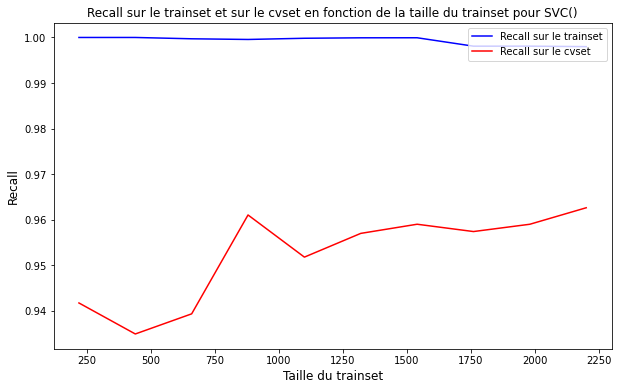

In [246]:
model = SVC() #le meilleur modele garde apres cross validation 
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "recall", train_sizes, n_jobs)

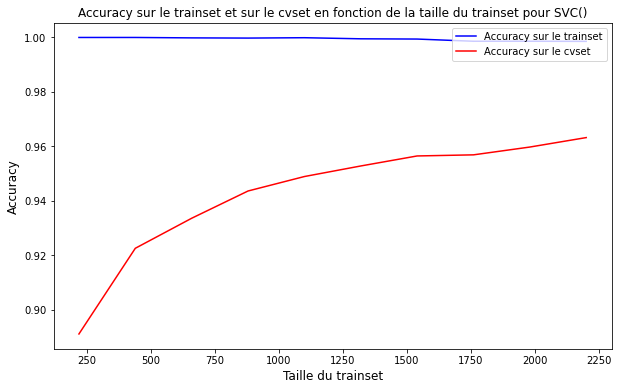

In [247]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "accuracy", train_sizes, n_jobs)

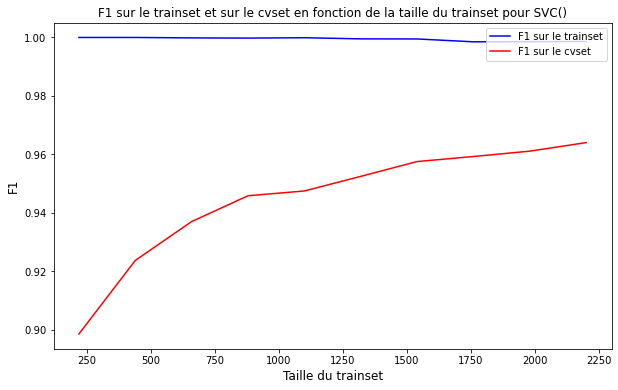

In [248]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "f1", train_sizes, n_jobs)

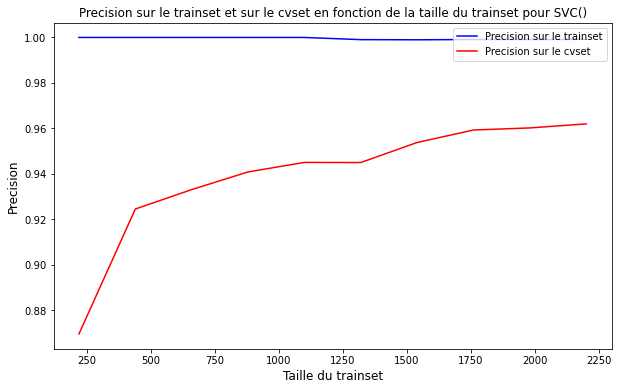

In [249]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "precision", train_sizes, n_jobs)